## Challenge: If a tree falls in the forest...
Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [1]:
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
#simplefilter(action='ignore', category=UndefinedMetricWarning)
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 999)
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
warnings.filterwarnings("ignore", category=mpl.cbook.MatplotlibDeprecationWarning)
import seaborn as sns
from sklearn import ensemble, tree
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [2]:
df = pd.read_csv(
    "../Datasets/processed.cleveland.data",
    header=None,
    na_values='?'
)
df = df.dropna()# only 6 rows
df.columns = [
'age' ,    
'sex'     ,
'cp'   ,
'trestbps',
'chol'    ,
'fbs'    ,
'restecg' ,
'thalach',
'exang'  ,
'oldpeak',
'slope'  ,
'ca'    ,
'thal'  ,
'num' 
]
#df.thal.astype('float').astype('int')
pp.ProfileReport(df, check_correlation=True)

Number of variables,15
Number of observations,297
Total Missing (%),0.0%
Total size in memory,34.9 KiB
Average record size in memory,120.3 B
Numeric,12
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,0


## Correlation

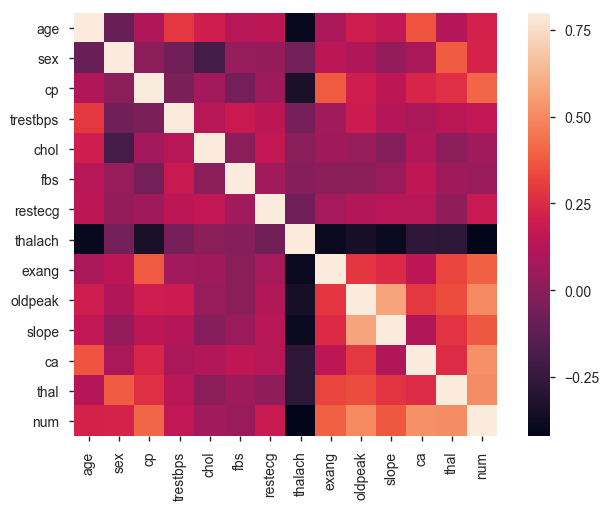

Top Absolute Correlations
oldpeak  slope      0.58
ca       num        0.52
thal     num        0.51
oldpeak  num        0.50
thalach  num        0.42
cp       num        0.40
age      thalach    0.39
exang    num        0.39
thalach  slope      0.39
         exang      0.38
sex      thal       0.38
cp       exang      0.38
slope    num        0.37
age      ca         0.36
thalach  oldpeak    0.35
oldpeak  thal       0.34
cp       thalach    0.34
exang    thal       0.33
oldpeak  ca         0.29
age      trestbps   0.29
exang    oldpeak    0.29
slope    thal       0.28
thalach  thal       0.27
         ca         0.27
cp       thal       0.27
ca       thal       0.26
exang    slope      0.25
cp       ca         0.24
sex      num        0.23
age      num        0.22


In [3]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

sns.heatmap(df.corr(), vmax=.8, square=True)
plt.show()
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 30).to_string())

In [4]:
X = df.drop(columns=['num'])
y = df.num

## Full features
### without Hyperparameter Tuning

In [5]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, y)

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    #random_state = 1338
)
dt.fit(X, y)

score = cross_val_score(rfc, X, y, cv=10)
print("RFC: Input X --> Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
score = cross_val_score(dt, X, y, cv=10)
print("DT: Input X --> Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
## RandomForest
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
y_pred = rfc.predict(X)
print('RFC:\n', classification_report(y, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4]))
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=2)
print('AUC: ', auc(fpr, tpr))
# DecisionTree
y_pred = dt.predict(X)
print('\nDT:\n', classification_report(y, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4]))
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=2)
print('AUC: ', auc(fpr, tpr))

RFC: Input X --> Accuracy: 0.562 (+/- 0.102)
DT: Input X --> Accuracy: 0.543 (+/- 0.130)
RFC:
               precision    recall  f1-score   support

     class 0       0.97      1.00      0.98       160
     class 1       0.98      0.94      0.96        54
     class 2       0.92      0.97      0.94        35
     class 3       1.00      0.91      0.96        35
     class 4       1.00      0.85      0.92        13

   micro avg       0.97      0.97      0.97       297
   macro avg       0.97      0.94      0.95       297
weighted avg       0.97      0.97      0.97       297

Confusion Matrix
 [[160   0   0   0   0]
 [  3  51   0   0   0]
 [  0   1  34   0   0]
 [  1   0   2  32   0]
 [  1   0   1   0  11]]
AUC:  0.8272082878953109

DT:
               precision    recall  f1-score   support

     class 0       0.77      0.86      0.81       160
     class 1       0.36      0.33      0.35        54
     class 2       0.31      0.60      0.41        35
     class 3       1.00      0.03 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Result: Random Forest performs much better than the Decision Tree

## Hyperparameter Tuning

### Random Forest Classifier:

In [6]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

rfc = ensemble.RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': range(1,50,5), 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, scoring=acc_scorer)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rfc = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rfc.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
score = cross_val_score(rfc, X, y, cv=10)
print("RFC: Input X --> Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
y_pred = rfc.predict(X)
print('RFC:\n', classification_report(y, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4]))
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=2)
print('AUC: ', auc(fpr, tpr))

RFC: Input X --> Accuracy: 0.589 (+/- 0.076)
RFC:
               precision    recall  f1-score   support

     class 0       0.73      0.99      0.84       160
     class 1       0.58      0.13      0.21        54
     class 2       0.74      0.49      0.59        35
     class 3       0.55      0.66      0.60        35
     class 4       0.67      0.15      0.25        13

   micro avg       0.70      0.70      0.70       297
   macro avg       0.65      0.48      0.50       297
weighted avg       0.68      0.70      0.64       297

Confusion Matrix
 [[159   1   0   0   0]
 [ 33   7   5   9   0]
 [ 12   2  17   4   0]
 [ 11   0   0  23   1]
 [  2   2   1   6   2]]
AUC:  0.6887677208287895


### Decision Tree

In [8]:
parameters={'max_features' : range(1,10,1),'max_depth': range(1,10,1)}
clf_tree=tree.DecisionTreeClassifier()
clf=GridSearchCV(clf_tree,parameters)
clf.fit(X,y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': range(1, 10), 'max_depth': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [9]:
score = cross_val_score(clf, X, y, cv=10)
print("DT: Input X --> Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
y_pred = clf.predict(X)
print('DT:\n', classification_report(y, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4]))
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=2)
print('AUC: ', auc(fpr, tpr))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprecati

DT: Input X --> Accuracy: 0.563 (+/- 0.076)
DT:
               precision    recall  f1-score   support

     class 0       0.71      0.96      0.81       160
     class 1       0.38      0.24      0.30        54
     class 2       0.55      0.17      0.26        35
     class 3       0.46      0.46      0.46        35
     class 4       0.00      0.00      0.00        13

   micro avg       0.63      0.63      0.63       297
   macro avg       0.42      0.37      0.37       297
weighted avg       0.57      0.63      0.58       297

Confusion Matrix
 [[153   3   0   4   0]
 [ 33  13   2   6   0]
 [ 15   8   6   6   0]
 [ 10   7   2  16   0]
 [  6   3   1   3   0]]
AUC:  0.6655398037077427


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics

## Selected Features 

In [13]:
rfc = ensemble.RandomForestClassifier()
for i in range(1,14):
    X_selKBest = SelectKBest(k=i).fit_transform(X, y)
    score = cross_val_score(rfc, X_selKBest, y, cv=10)
    print("k=%s, RFC: Input X_selKBest --> Accuracy: %0.3f (+/- %0.3f)" % (i, score.mean(), score.std() * 2))

k=1, RFC: Input X_selKBest --> Accuracy: 0.519 (+/- 0.138)
k=2, RFC: Input X_selKBest --> Accuracy: 0.575 (+/- 0.101)
k=3, RFC: Input X_selKBest --> Accuracy: 0.542 (+/- 0.194)
k=4, RFC: Input X_selKBest --> Accuracy: 0.527 (+/- 0.173)
k=5, RFC: Input X_selKBest --> Accuracy: 0.541 (+/- 0.090)
k=6, RFC: Input X_selKBest --> Accuracy: 0.551 (+/- 0.137)
k=7, RFC: Input X_selKBest --> Accuracy: 0.596 (+/- 0.116)
k=8, RFC: Input X_selKBest --> Accuracy: 0.586 (+/- 0.141)
k=9, RFC: Input X_selKBest --> Accuracy: 0.530 (+/- 0.125)
k=10, RFC: Input X_selKBest --> Accuracy: 0.588 (+/- 0.127)
k=11, RFC: Input X_selKBest --> Accuracy: 0.596 (+/- 0.089)
k=12, RFC: Input X_selKBest --> Accuracy: 0.565 (+/- 0.131)
k=13, RFC: Input X_selKBest --> Accuracy: 0.562 (+/- 0.122)


In [11]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
# Instantiate and fit our model.
rfc = ensemble.RandomForestClassifier()

X_nor = StandardScaler().fit_transform(X)

for i in range(1,14):
    sklearn_pca = PCA(n_components=i)
    X_pca = sklearn_pca.fit_transform(X_nor)
    score = cross_val_score(rfc, X_pca, y, cv=10)
    print("components count=%s, RFC: Input X_selKBest --> Accuracy: %0.3f (+/- %0.3f)" % (i, score.mean(), score.std() * 2))

components count=1, RFC: Input X_selKBest --> Accuracy: 0.537 (+/- 0.129)
components count=2, RFC: Input X_selKBest --> Accuracy: 0.542 (+/- 0.088)
components count=3, RFC: Input X_selKBest --> Accuracy: 0.592 (+/- 0.138)
components count=4, RFC: Input X_selKBest --> Accuracy: 0.569 (+/- 0.062)
components count=5, RFC: Input X_selKBest --> Accuracy: 0.546 (+/- 0.136)
components count=6, RFC: Input X_selKBest --> Accuracy: 0.559 (+/- 0.098)
components count=7, RFC: Input X_selKBest --> Accuracy: 0.551 (+/- 0.149)
components count=8, RFC: Input X_selKBest --> Accuracy: 0.557 (+/- 0.105)
components count=9, RFC: Input X_selKBest --> Accuracy: 0.564 (+/- 0.145)
components count=10, RFC: Input X_selKBest --> Accuracy: 0.582 (+/- 0.084)
components count=11, RFC: Input X_selKBest --> Accuracy: 0.566 (+/- 0.114)
components count=12, RFC: Input X_selKBest --> Accuracy: 0.558 (+/- 0.143)
components count=13, RFC: Input X_selKBest --> Accuracy: 0.549 (+/- 0.070)


Best Pick: components count=10, RFC: Input X_selKBest --> Accuracy: 0.582 (+/- 0.084)